In [259]:
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from datetime import datetime, timedelta
from pandas import DataFrame

## Import and clean Data

In [260]:
def process(dfurl):

    dfcovid = pd.read_csv(dfurl)
    dfcovid = dfcovid.drop(['UID','iso2', 'iso3','code3', 'FIPS', 'Lat', 'Long_' , 'Country_Region', 'Combined_Key'], axis=1)
    dfcovid.rename(columns = {'Province_State':'State'} , inplace=True)
    dfcovid.rename(columns = {'Admin2':'County'} , inplace=True)
    dfcovid = dfcovid.fillna("NA")
    dfcovid = dfcovid.melt(['State', 'County'], var_name='Date', value_name='value')
    
    return dfcovid

In [261]:
#Import file for confirmed cases per US State and County
urlconfirmed = 'https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_US.csv'
dfconfirmed = process(urlconfirmed)
dfconfirmed.rename(columns = {'value':'Confirmed'} , inplace=True)
dfconfirmed['Date'] = pd.to_datetime(dfconfirmed.Date)
dfconfirmed.head()

,State,County,Date,Confirmed
0,Alabama,Autauga,2020-01-22,0
1,Alabama,Baldwin,2020-01-22,0
2,Alabama,Barbour,2020-01-22,0
3,Alabama,Bibb,2020-01-22,0
4,Alabama,Blount,2020-01-22,0


In [262]:
#Import file for Dead cases per US State and County
urldead = 'https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_deaths_US.csv'
dfdead = process(urldead)
dfdead = dfdead[dfdead.Date != 'Population']
dfdead.rename(columns = {'value':'Dead'} , inplace=True)
dfdead['Date'] = pd.to_datetime(dfdead.Date)
dfdead.head()

,State,County,Date,Dead
3340,Alabama,Autauga,2020-01-22,0
3341,Alabama,Baldwin,2020-01-22,0
3342,Alabama,Barbour,2020-01-22,0
3343,Alabama,Bibb,2020-01-22,0
3344,Alabama,Blount,2020-01-22,0


In [263]:
#Merge Confirmed and Dead case numbers on State, County and Date
uscovid = pd.merge(dfconfirmed, dfdead, how='left', left_on=['State', 'County','Date'], right_on = ['State','County', 'Date'])

In [264]:
uscovid.head()

,State,County,Date,Confirmed,Dead
0,Alabama,Autauga,2020-01-22,0,0
1,Alabama,Baldwin,2020-01-22,0,0
2,Alabama,Barbour,2020-01-22,0,0
3,Alabama,Bibb,2020-01-22,0,0
4,Alabama,Blount,2020-01-22,0,0


## Get Hospital all beds data

In [265]:
hosp_uti_url = 'https://raw.githubusercontent.com/JieYingWu/COVID-19_US_County-level_Summaries/master/data/Hospitalization_all_locs.csv'
hospital_utilization = pd.read_csv(hosp_uti_url ) 
hospital_utilization = hospital_utilization[hospital_utilization['Attribute'] == 'allbed_mean']
hospital_utilization = hospital_utilization.melt(['State', 'Attribute'], var_name='Date', value_name='allbed_mean')
hospital_utilization['Date'] = pd.to_datetime(hospital_utilization.Date)
hospital_utilization = hospital_utilization.drop(['Attribute'], axis=1)
hospital_utilization

,State,Date,allbed_mean
0,Alabama,2019-12-13,0.0
1,Alaska,2019-12-13,0.0
2,Arizona,2019-12-13,0.0
3,Arkansas,2019-12-13,0.0
4,California,2019-12-13,0.0
...,...,...,...
13051,Virginia,2020-08-24,0.0
13052,Washington,2020-08-24,0.0
13053,West Virginia,2020-08-24,0.0
13054,Wisconsin,2020-08-24,0.0


In [266]:
uscovid_statelevel = uscovid
uscovid_statelevel.drop('County', axis =1)
uscovid_st_dt = pd.DataFrame(uscovid_statelevel.groupby(['State','Date']).agg({'Confirmed': 'sum', 'Dead': 'sum'})).reset_index()
uscovid_st_dt.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12470 entries, 0 to 12469
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   State      12470 non-null  object        
 1   Date       12470 non-null  datetime64[ns]
 2   Confirmed  12470 non-null  int64         
 3   Dead       12470 non-null  int64         
dtypes: datetime64[ns](1), int64(2), object(1)
memory usage: 389.8+ KB


In [267]:
uscovid_st_dt = pd.merge(uscovid_st_dt, hospital_utilization, how='left')

In [268]:
uscovid_st_dt.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 12470 entries, 0 to 12469
Data columns (total 5 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   State        12470 non-null  object        
 1   Date         12470 non-null  datetime64[ns]
 2   Confirmed    12470 non-null  int64         
 3   Dead         12470 non-null  int64         
 4   allbed_mean  10965 non-null  float64       
dtypes: datetime64[ns](1), float64(1), int64(2), object(1)
memory usage: 584.5+ KB


In [269]:
print(uscovid_st_dt.sort_values('allbed_mean', ascending=True))

                State       Date  Confirmed  Dead  allbed_mean
0             Alabama 2020-01-22          0     0          0.0
6507          Montana 2020-03-19         11     0          0.0
6506          Montana 2020-03-18         10     0          0.0
6505          Montana 2020-03-17          8     0          0.0
6504          Montana 2020-03-16          6     0          0.0
...               ...        ...        ...   ...          ...
11390  Virgin Islands 2020-08-19        828     9          NaN
11391  Virgin Islands 2020-08-20        869    10          NaN
11392  Virgin Islands 2020-08-21        932    10          NaN
11393  Virgin Islands 2020-08-22        932    10          NaN
11394  Virgin Islands 2020-08-23        932    10          NaN

[12470 rows x 5 columns]


## Join Census Data

In [270]:
#Import Census Data
census = pd.read_csv("C:/Users/ysman/Documents/springboard/CAPSTONE 2/Covid/covidpython/nst-est2019-alldata.csv", header=0)
census_col_list = ['NAME' , 'POPESTIMATE2019']
census2019 = census[census_col_list ]

census2019.rename(columns = {'POPESTIMATE2019':'Population'}, inplace = True)
census2019.rename(columns =  {'NAME':'State'}, inplace = True)
census2019.head()

,State,Population
0,Alabama,4903185
1,Alaska,731545
2,Arizona,7278717
3,Arkansas,3017804
4,California,39512223


In [271]:
# Merge Census data into main df
uscovid_st_dt = pd.merge(uscovid_st_dt, census2019, how='left')
uscovid_st_dt.head()

,State,Date,Confirmed,Dead,allbed_mean,Population
0,Alabama,2020-01-22,0,0,0.0,4903185.0
1,Alabama,2020-01-23,0,0,0.0,4903185.0
2,Alabama,2020-01-24,0,0,0.0,4903185.0
3,Alabama,2020-01-25,0,0,0.0,4903185.0
4,Alabama,2020-01-26,0,0,0.0,4903185.0


## Create columns for Total Confirmed and Total Dead

In [272]:
TotalConfirmed = uscovid_st_dt.groupby(['State'])['Confirmed'].sum()
Totaldf = TotalConfirmed.to_frame().reset_index()
Totaldf.rename(columns =  {'Confirmed':'Total_Confirmed'}, inplace = True)
Totaldf.head()

,State,Total_Confirmed
0,Alabama,5604700
1,Alaska,187592
2,American Samoa,0
3,Arizona,10298799
4,Arkansas,2742056


In [273]:
TotalDead = uscovid_st_dt.groupby(['State'])['Dead'].sum()
Totaldf2 = TotalDead.to_frame().reset_index()
Totaldf2.rename(columns =  {'Dead':'Total_Dead'}, inplace = True)

In [274]:
#Merge Total Confirmed and TotalDead in uscovid file
uscovid_st_dt = pd.merge(uscovid_st_dt, Totaldf, how='left')

In [275]:
uscovid_st_dt = pd.merge(uscovid_st_dt, Totaldf2, how='left')

In [276]:
uscovid_st_dt.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 12470 entries, 0 to 12469
Data columns (total 8 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   State            12470 non-null  object        
 1   Date             12470 non-null  datetime64[ns]
 2   Confirmed        12470 non-null  int64         
 3   Dead             12470 non-null  int64         
 4   allbed_mean      10965 non-null  float64       
 5   Population       11180 non-null  float64       
 6   Total_Confirmed  12470 non-null  int64         
 7   Total_Dead       12470 non-null  int64         
dtypes: datetime64[ns](1), float64(2), int64(4), object(1)
memory usage: 876.8+ KB


## Finding TOP 10 states with confirmed covid patients:

In [277]:
maxdate = uscovid_st_dt['Date'].max()

In [278]:
dflatest = uscovid_st_dt[uscovid_st_dt['Date'] == maxdate]

In [279]:
dflatest.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 58 entries, 214 to 12469
Data columns (total 8 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   State            58 non-null     object        
 1   Date             58 non-null     datetime64[ns]
 2   Confirmed        58 non-null     int64         
 3   Dead             58 non-null     int64         
 4   allbed_mean      51 non-null     float64       
 5   Population       52 non-null     float64       
 6   Total_Confirmed  58 non-null     int64         
 7   Total_Dead       58 non-null     int64         
dtypes: datetime64[ns](1), float64(2), int64(4), object(1)
memory usage: 4.1+ KB


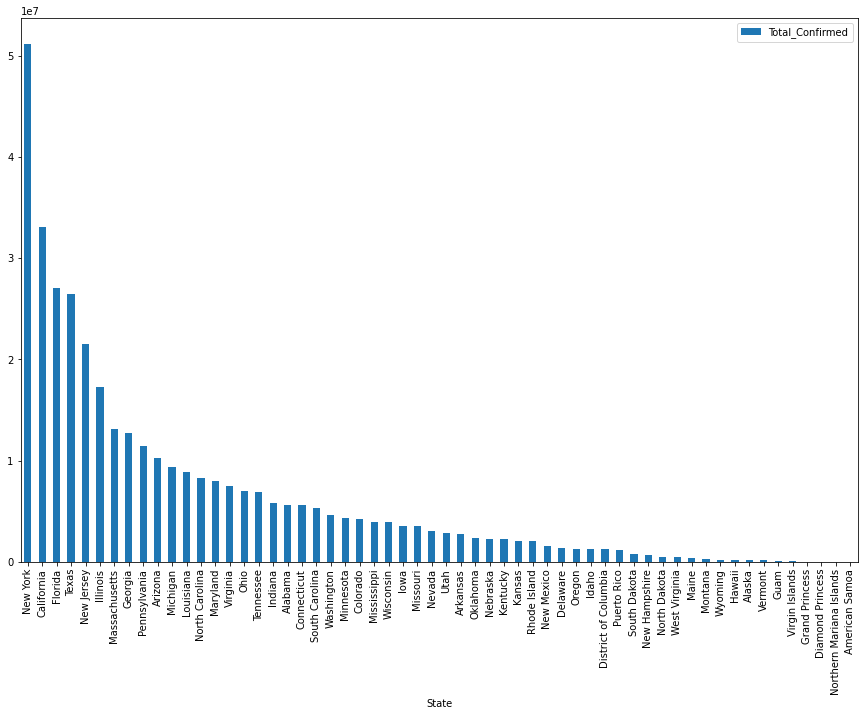

In [258]:
dflatest = dflatest.sort_values('Total_Confirmed', ascending=False)
by_confirmed  = dflatest.plot.bar(x='State', y='Total_Confirmed', figsize=(15,10))

In [280]:
statelist = dflatest['State'].tolist()
statelist_top10 =statelist[:10]
print(statelist_top10)

['Alabama', 'Alaska', 'American Samoa', 'Arizona', 'Arkansas', 'California', 'Colorado', 'Connecticut', 'Delaware', 'Diamond Princess']


In [281]:
uscovid_Top10 = uscovid_st_dt[uscovid_st_dt['State'].isin(statelist_top10)]
uscovid_Top10.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2150 entries, 0 to 2149
Data columns (total 8 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   State            2150 non-null   object        
 1   Date             2150 non-null   datetime64[ns]
 2   Confirmed        2150 non-null   int64         
 3   Dead             2150 non-null   int64         
 4   allbed_mean      1720 non-null   float64       
 5   Population       1720 non-null   float64       
 6   Total_Confirmed  2150 non-null   int64         
 7   Total_Dead       2150 non-null   int64         
dtypes: datetime64[ns](1), float64(2), int64(4), object(1)
memory usage: 151.2+ KB


# Insights
## Forcast Hospital Bed need for the top 10 states

In [282]:
import pandas as pd
from fbprophet import Prophet

In [283]:
statel = ['California']
CA = uscovid_Top10[uscovid_Top10['State']== 'California']
CA.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 215 entries, 1075 to 1289
Data columns (total 8 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   State            215 non-null    object        
 1   Date             215 non-null    datetime64[ns]
 2   Confirmed        215 non-null    int64         
 3   Dead             215 non-null    int64         
 4   allbed_mean      215 non-null    float64       
 5   Population       215 non-null    float64       
 6   Total_Confirmed  215 non-null    int64         
 7   Total_Dead       215 non-null    int64         
dtypes: datetime64[ns](1), float64(2), int64(4), object(1)
memory usage: 15.1+ KB


In [284]:
CA.set_index('Date', inplace=True)

In [285]:
CA

,State,Confirmed,Dead,allbed_mean,Population,Total_Confirmed,Total_Dead
Date,,,,,,,
2020-01-22,California,0,0,0.0,39512223.0,33120293,764365
2020-01-23,California,0,0,0.0,39512223.0,33120293,764365
2020-01-24,California,0,0,0.0,39512223.0,33120293,764365
2020-01-25,California,0,0,0.0,39512223.0,33120293,764365
2020-01-26,California,2,0,0.0,39512223.0,33120293,764365
...,...,...,...,...,...,...,...
2020-08-19,California,647274,11690,0.0,39512223.0,33120293,764365
2020-08-20,California,652267,11810,0.0,39512223.0,33120293,764365
2020-08-21,California,658900,11946,0.0,39512223.0,33120293,764365


In [296]:
CA['Confirmed_per_1000']= CA.apply(lambda row: (row.Confirmed * 1000)/ row.Population , axis = 1).round(2)


C:\Users\ysman\anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [295]:
CA['Daily_Confirmed'] = CA['Confirmed'].diff().round(2)

C:\Users\ysman\anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [293]:
CA['%Daily_confirmed'] = CA.apply(lambda row: (row.Daily_Confirmed * 100)/ row.Total_Confirmed , axis = 1).round(2)
CA['Daily_change_rate'] = (CA['%Daily_confirmed'] .diff()).round(2)

C:\Users\ysman\anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
C:\Users\ysman\anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [297]:
CA

,State,Confirmed,Dead,allbed_mean,Population,Total_Confirmed,Total_Dead,Confirmed_per_1000,Daily_Confirmed,%Daily_confirmed,Daily_change_rate
Date,,,,,,,,,,,
2020-01-22,California,0,0,0.0,39512223.0,33120293,764365,0.00,NaN,NaN,NaN
2020-01-23,California,0,0,0.0,39512223.0,33120293,764365,0.00,0.0,0.00,NaN
2020-01-24,California,0,0,0.0,39512223.0,33120293,764365,0.00,0.0,0.00,0.00
2020-01-25,California,0,0,0.0,39512223.0,33120293,764365,0.00,0.0,0.00,0.00
2020-01-26,California,2,0,0.0,39512223.0,33120293,764365,0.00,2.0,0.00,0.00
...,...,...,...,...,...,...,...,...,...,...,...
2020-08-19,California,647274,11690,0.0,39512223.0,33120293,764365,16.38,9134.0,0.03,0.00
2020-08-20,California,652267,11810,0.0,39512223.0,33120293,764365,16.51,4993.0,0.02,-0.01
2020-08-21,California,658900,11946,0.0,39512223.0,33120293,764365,16.68,6633.0,0.02,0.00
